In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
sns.set_style('darkgrid')

In [4]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

FileNotFoundError: [Errno 2] File ../input/titanic/train.csv does not exist: '../input/titanic/train.csv'

Exploratory Section

In [5]:
#train data head
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
#test data head
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Finding null value in train data**

In [7]:
#data info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


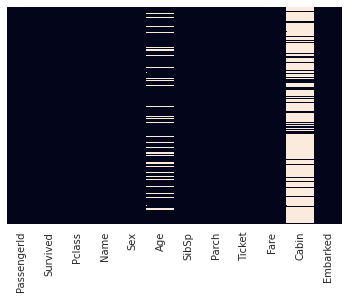

In [8]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

In [9]:
#percentage of missing Age and Cabin Data
age_miss = ((train[train['Age'].isnull()==True].index.size)/train.index.size)*100
print("Missing Age Data: " + str(round(float(age_miss), 1)) + "%")
cabin_miss = ((train[train['Cabin'].isnull()==True].index.size)/train.index.size)*100
print("Missing Cabin Data: " + str(round(float(cabin_miss),1)) + "%")

Missing Age Data: 19.9%
Missing Cabin Data: 77.1%


**There are to much missing cabin data, might as well just drop it**

In [10]:
train = train.drop('Cabin', axis=1)

**Filling up age data**

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


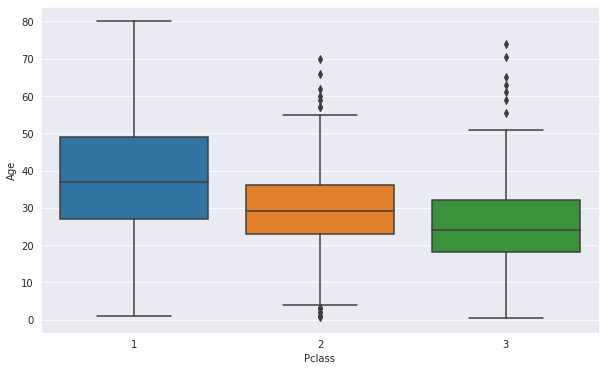

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Pclass', y='Age', data=train)

**Seems like passengers in 1st class are generally older than the other 2 classes, and the age mean for each class decreases as class changes from 1st to 3rd**

In [13]:
#finding mean age for each class
first_mean = round(train[train['Pclass']==1]['Age'].mean())
sec_mean = round(train[train['Pclass']==2]['Age'].mean())
third_mean = round(train[train['Pclass']==3]['Age'].mean())
print("First class age mean: " + str(first_mean))
print("Second class age mean: " + str(sec_mean))
print("Third class age mean: " + str(third_mean))

First class age mean: 38
Second class age mean: 30
Third class age mean: 25


**Instead of filling unknown age value with random or other methods, it would be best to fill it with the mean value of age according to the passenger class**

In [14]:
#actually filling up the unknown Age value according to age mean for each class

def fill_age(col):
    Age = col[0]
    Pclass = col[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            return first_mean
        elif Pclass == 2:
            return sec_mean
        else:
            return third_mean
    
    else:
        return Age

In [15]:
train['Age'] = train[['Age', 'Pclass']].apply(fill_age, axis=1)

In [16]:
#confirm no more missing data
train[train.isnull()==True].index

RangeIndex(start=0, stop=891, step=1)

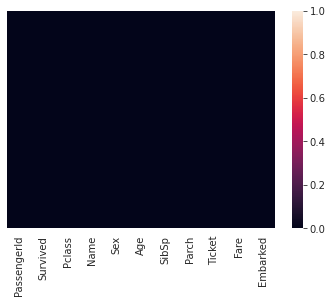

In [17]:
sns.heatmap(train.isnull()==True, yticklabels=False)

**Grouping Age**

* child = group 1
* teen = group 2
* young adult = group 3
* adult = group 4
* elderly =group 5


In [18]:
def age_group(col):
    Age = col[0]
    
    if Age<13:
        return 1
    elif 13<= Age <= 18:
        return 2
    elif 19<= Age <= 27:
        return 3
    elif 27<= Age <=50:
        return 4
    else:
        return 5

In [19]:
train['age_group'] = train[['Age']].apply(age_group, axis=1)


In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,4


**Changing sex column into categorical feature**

In [21]:
sex = pd.get_dummies(train['Sex'])
sex.head()

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [22]:
#reducing column to male only, therefore 1 is male 0 is female, this is to reduce data needed
sex = pd.get_dummies(train['Sex'], drop_first=True)
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [23]:
#combining this categorical feature with train dataframe
train = pd.concat([train, sex], axis=1)

In [24]:
train = train.drop('Sex', axis=1)
train.rename(columns ={'male': 'gender'}, inplace=True)

In [25]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group,gender
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,3,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,4,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,3,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,4,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,4,1
5,6,0,3,"Moran, Mr. James",25.0,0,0,330877,8.4583,Q,3,1
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,S,5,1
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,S,1,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,S,3,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,C,2,0


**Categorize the passenger title based on their respective title in the name column**

* miss =group 1,
* mr  = group 2,
* mrs = group 3,
* master = group 4,
* other =group 5

In [26]:
#categorical feature from passenger title
titles = ['Miss.', 'Mr.', 'Mrs.', 'Master.']

def find_title(col):
    Name = col[0]
    
    passname = str(col).split()
    
    if titles[0] in passname:
        return 1
    elif titles[1] in passname:
        return 2
    elif titles[2] in passname:
        return 3
    elif titles[3] in passname:
        return 4
    else:
        return 5

In [27]:
train['titles_group'] = train[['Name']].apply(find_title, axis=1)

In [28]:
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group,gender,titles_group
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,3,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,4,0,3
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,3,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,4,0,3
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,4,1,2


**Categorize embark column**

In [29]:
def embark(col):
    embarked = col[0]
    
    if embarked == 'S':
        return 1
    elif embarked == 'C':
        return 2
    else:
        return 3

In [30]:
train['embark_group'] = train[['Embarked']].apply(embark, axis=1)

In [31]:
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group,gender,titles_group,embark_group
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,3,1,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,4,0,3,2
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,3,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,4,0,3,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,4,1,2,1


In [32]:
train = train.drop(['Name', 'Embarked', 'Ticket'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age_group,gender,titles_group,embark_group
0,1,0,3,22.0,1,0,7.2500,3,1,2,1
1,2,1,1,38.0,1,0,71.2833,4,0,3,2
2,3,1,3,26.0,0,0,7.9250,3,0,1,1
3,4,1,1,35.0,1,0,53.1000,4,0,3,1
4,5,0,3,35.0,0,0,8.0500,4,1,2,1


**Fare still contains too much uncategorized unique data, let's try to categorize them**

In [33]:
train['Fare'] = train['Fare'].astype(int)

In [34]:
train['Fare'].unique()

array([  7,  71,  53,   8,  51,  21,  11,  30,  16,  26,  31,  29,  13,
        18,  35, 263,  27, 146,  10,  82,  52,   9,  41,  15,  17,  39,
        76,  61,  46,  80,  83,  73,  14,  56,  12,  47,  34,  20,  63,
        23,  77,  24, 247,  22,   6,  79,  36,  66,  69,  55,  25,  33,
        28,   0,  50, 113,  90,  86, 512, 153, 135,  19,  78,  91, 151,
       110, 108, 262, 164, 134,  57, 133,  75, 211,   4, 227, 120,  32,
        81,  89,  38,  49,  59,  93, 221, 106,  40,  42,  65,  37,   5])

In [35]:
train['Fare'].mean()

31.78563411896745

In [36]:
print ('Q1: '  + str(train['Fare'].quantile(0.25)))
print ('median: ' + str(train['Fare'].median()))
print ('Q3: ' + str(train['Fare'].quantile(0.75)))

Q1: 7.0
median: 14.0
Q3: 31.0


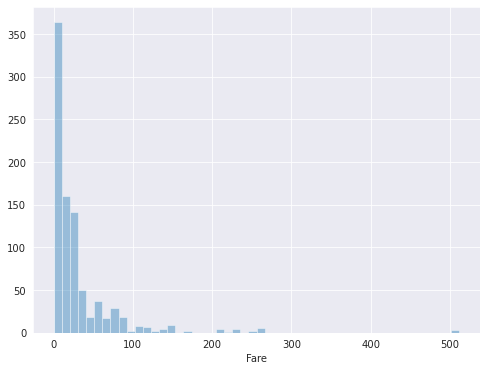

In [37]:
plt.figure(figsize=(8,6))
sns.distplot(train['Fare'], kde=False, bins=50)

**Most of the fares are below 100, this means that the 0-100 range should be separated into more group than the 100+ range**

In [38]:
def fare_group(col):
    fare = col[0]
    
    if fare <= 7:
        return 1
    elif 7< fare <=15:
        return 2
    elif 15< fare <= 31:
        return 3
    elif 31< fare <= 99:
        return 4
    elif 99< fare <=200:
        return 5
    else:
        return 6
    

In [39]:
train['fare_group'] = train[['Fare']].apply(fare_group, axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age_group,gender,titles_group,embark_group,fare_group
0,1,0,3,22.0,1,0,7,3,1,2,1,1
1,2,1,1,38.0,1,0,71,4,0,3,2,4
2,3,1,3,26.0,0,0,7,3,0,1,1,1
3,4,1,1,35.0,1,0,53,4,0,3,1,4
4,5,0,3,35.0,0,0,8,4,1,2,1,2


In [40]:
train = train.drop('Fare', axis=1)

In [41]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,age_group,gender,titles_group,embark_group,fare_group
0,1,0,3,22.0,1,0,3,1,2,1,1
1,2,1,1,38.0,1,0,4,0,3,2,4
2,3,1,3,26.0,0,0,3,0,1,1,1
3,4,1,1,35.0,1,0,4,0,3,1,4
4,5,0,3,35.0,0,0,4,1,2,1,2


In [42]:
tcor = train.drop('PassengerId', axis=1).corr()

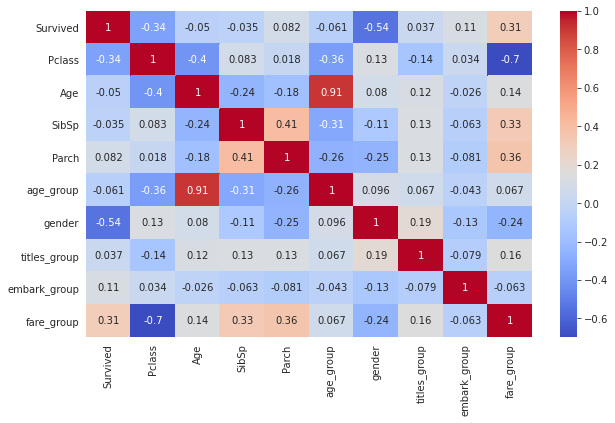

In [43]:
plt.figure(figsize=(10,6))
sns.heatmap(tcor, annot=True, cmap ='coolwarm')

**Looks like survival chance has the highest correlation with age group**

# **Since the train data is 'final', the same method may be applied to test data**

In [44]:
test = pd.read_csv('../input/titanic/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


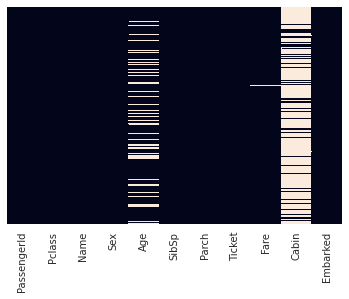

In [45]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False)

In [46]:
#drop cabin
test = test.drop('Cabin', axis=1)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [47]:
#fill unknown age values and age-grouping
test['Age'] = test[['Age', 'Pclass']].apply(fill_age, axis=1)
test['age_group'] = test[['Age']].apply(age_group, axis=1)

In [48]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,4
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,4
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,5
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,3


In [49]:
#sex categorizing
t_sex = pd.get_dummies(test['Sex'], drop_first=True)
t_sex.head()

,male
0,1
1,0
2,1
3,1
4,0


In [50]:
test = pd.concat([test, t_sex], axis=1)

In [51]:
test = test.drop('Sex', axis=1)
test.rename(columns ={'male': 'gender'}, inplace=True)
test.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group,gender
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,Q,4,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,S,4,0
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,Q,5,1
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,S,3,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,S,3,0


In [52]:
#title grouping
test['titles_group'] = test[['Name']].apply(find_title, axis=1)
test.head(2)

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group,gender,titles_group
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,Q,4,1,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,S,4,0,3


In [53]:
#embark grouping
test['embark_group'] = test[['Embarked']].apply(embark, axis=1)

In [54]:
#fare grouping
test['fare_group'] = test[['Fare']].apply(fare_group, axis=1)
test.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,age_group,gender,titles_group,embark_group,fare_group
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,Q,4,1,2,3,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,S,4,0,3,1,1
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,Q,5,1,2,3,2
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,S,3,1,2,1,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,S,3,0,3,1,2


In [55]:
test = test.drop(['Name', 'Embarked', 'Ticket', 'Fare'], axis=1)
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,age_group,gender,titles_group,embark_group,fare_group
0,892,3,34.5,0,0,4,1,2,3,2
1,893,3,47.0,1,0,4,0,3,1,1
2,894,2,62.0,0,0,5,1,2,3,2
3,895,3,27.0,0,0,3,1,2,1,2
4,896,3,22.0,1,1,3,0,3,1,2


**all data cleansing method applied, test data is final and may be used for machine learning**

END OF EXPLORATORY

# MACHINE LEARNING SECTION

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [57]:
#check data one more time
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,age_group,gender,titles_group,embark_group,fare_group
0,1,0,3,22.0,1,0,3,1,2,1,1
1,2,1,1,38.0,1,0,4,0,3,2,4
2,3,1,3,26.0,0,0,3,0,1,1,1
3,4,1,1,35.0,1,0,4,0,3,1,4
4,5,0,3,35.0,0,0,4,1,2,1,2


In [58]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,age_group,gender,titles_group,embark_group,fare_group
0,892,3,34.5,0,0,4,1,2,3,2
1,893,3,47.0,1,0,4,0,3,1,1
2,894,2,62.0,0,0,5,1,2,3,2
3,895,3,27.0,0,0,3,1,2,1,2
4,896,3,22.0,1,1,3,0,3,1,2


In [59]:
X_train = train.drop(['PassengerId', 'Survived'], axis=1)
y_train = train['Survived']
X_test = test.drop(['PassengerId'], axis=1)

# Logistic regression method

this method is used because the outcome will always be either 0 or 1

In [60]:
logmodel = LogisticRegression()

In [61]:
logmodel.fit(X_train, y_train)

LogisticRegression()

In [62]:
log_pred = logmodel.predict(X_test)

In [63]:
log_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [64]:
log_model_pred = pd.DataFrame(log_pred, columns=['log_Survived'])
log_model_pred.head()

,log_Survived
0,0
1,0
2,0
3,0
4,1


In [65]:
log_model_pred.value_counts()

log_Survived
0               259
1               159
dtype: int64

# DecisionTree Classifier Method

In [66]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [67]:
dtree_pred = dtree.predict(X_test)

In [68]:
dtree_model_pred=pd.DataFrame(dtree_pred, columns=['dtree_Survived'])
dtree_model_pred.value_counts()

dtree_Survived
0                 258
1                 160
dtype: int64

# RandomTreeClassifier Method

In [69]:
rtree = RandomForestClassifier(n_estimators=500)
rtree.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [70]:
rtree_pred = rtree.predict(X_test)

In [71]:
rtree_model_pred = pd.DataFrame(rtree_pred, columns=['rtree_Survived'])

In [72]:
rtree_model_pred.value_counts()

rtree_Survived
0                 271
1                 147
dtype: int64

In [73]:
#joining all result for better view
survivor_data = pd.concat([log_model_pred, dtree_model_pred, rtree_model_pred], axis=1)
survivor_data.head()

,log_Survived,dtree_Survived,rtree_Survived
0,0,0,0
1,0,0,0
2,0,1,0
3,0,1,1
4,1,1,1


In [74]:
#joining with test data
test_fitted = pd.concat([test, survivor_data], axis=1)
test_fitted.head()

,PassengerId,Pclass,Age,SibSp,Parch,age_group,gender,titles_group,embark_group,fare_group,log_Survived,dtree_Survived,rtree_Survived
0,892,3,34.5,0,0,4,1,2,3,2,0,0,0
1,893,3,47.0,1,0,4,0,3,1,1,0,0,0
2,894,2,62.0,0,0,5,1,2,3,2,0,1,0
3,895,3,27.0,0,0,3,1,2,1,2,0,1,1
4,896,3,22.0,1,1,3,0,3,1,2,1,1,1


# Model evaluation 1

In [75]:
#finding where the difference between all model occur
test_fitted[(test_fitted['log_Survived'] != test_fitted['dtree_Survived']) | 
            (test_fitted['log_Survived'] != test_fitted['rtree_Survived']) |
            (test_fitted['dtree_Survived'] != test_fitted['rtree_Survived'])].count()

PassengerId       110
Pclass            110
Age               110
SibSp             110
Parch             110
age_group         110
gender            110
titles_group      110
embark_group      110
fare_group        110
log_Survived      110
dtree_Survived    110
rtree_Survived    110
dtype: int64

In [76]:
test_fitted[(test_fitted['log_Survived'] != test_fitted['dtree_Survived']) | 
            (test_fitted['log_Survived'] != test_fitted['rtree_Survived']) |
            (test_fitted['dtree_Survived'] != test_fitted['rtree_Survived'])].index

Int64Index([  2,   3,   6,   8,  17,  19,  21,  23,  27,  28,
            ...
            390, 392, 403, 404, 405, 408, 409, 410, 412, 417],
           dtype='int64', length=110)

**There are 100 different data where the 3 models used in this project resulted in different prediction**

**Now lets find out which two models have the most similarity to each other**

In [77]:
test_fitted[test_fitted['log_Survived'] != test_fitted['dtree_Survived']].count()

PassengerId       99
Pclass            99
Age               99
SibSp             99
Parch             99
age_group         99
gender            99
titles_group      99
embark_group      99
fare_group        99
log_Survived      99
dtree_Survived    99
rtree_Survived    99
dtype: int64

In [78]:
test_fitted[test_fitted['log_Survived'] != test_fitted['rtree_Survived']].count()

PassengerId       74
Pclass            74
Age               74
SibSp             74
Parch             74
age_group         74
gender            74
titles_group      74
embark_group      74
fare_group        74
log_Survived      74
dtree_Survived    74
rtree_Survived    74
dtype: int64

In [79]:
test_fitted[test_fitted['dtree_Survived'] != test_fitted['rtree_Survived']].count()

PassengerId       47
Pclass            47
Age               47
SibSp             47
Parch             47
age_group         47
gender            47
titles_group      47
embark_group      47
fare_group        47
log_Survived      47
dtree_Survived    47
rtree_Survived    47
dtype: int64

**From the count above, we can see that dtree and rtree have the most similarity, only 47 different ouputs, while logistic regression has 99 different output to dtree and 74 to rtree**

In [113]:
print("Number of unique values of age in prediction difference: ")
print(str(test_fitted[(test_fitted['log_Survived'] != test_fitted['dtree_Survived']) | 
            (test_fitted['log_Survived'] != test_fitted['rtree_Survived']) |
            (test_fitted['dtree_Survived'] != test_fitted['rtree_Survived'])]['Age'].nunique()))

Number of unique values of age in prediction difference: 
49


In [114]:
print("Number of unique values of fare group in prediction difference: ")
print(str(test_fitted[(test_fitted['log_Survived'] != test_fitted['dtree_Survived']) | 
            (test_fitted['log_Survived'] != test_fitted['rtree_Survived']) |
            (test_fitted['dtree_Survived'] != test_fitted['rtree_Survived'])]['fare_group'].nunique()))

Number of unique values of fare group in prediction difference: 
6


In [115]:
print("Number of unique values of titles_group in prediction difference: ")
print(str(test_fitted[(test_fitted['log_Survived'] != test_fitted['dtree_Survived']) | 
            (test_fitted['log_Survived'] != test_fitted['rtree_Survived']) |
            (test_fitted['dtree_Survived'] != test_fitted['rtree_Survived'])]['titles_group'].nunique()))

Number of unique values of titles_group in prediction difference: 
5


**Age seems to cause confusion, lets try using only age_group instead**

In [83]:
X_train_new= train.drop(['PassengerId', 'Age', 'Survived'], axis=1)
y_train_new = train['Survived']
X_test_new = test.drop(['PassengerId', 'Age'], axis=1)

In [84]:
log2 = LogisticRegression()
log2.fit(X_train_new, y_train_new)
log_pred2 = log2.predict(X_test_new)

In [85]:
dtree2 = DecisionTreeClassifier()
dtree2.fit(X_train_new, y_train_new)
dtree_pred2 = dtree2.predict(X_test_new)

In [86]:
rtree2 = RandomForestClassifier()
rtree2.fit(X_train_new, y_train_new)
rtree_pred2 = rtree2.predict(X_test_new)

In [87]:
log_model_new = pd.DataFrame(log_pred2, columns=['log_Survived_new'])
dtree_model_new = pd.DataFrame(dtree_pred2, columns=['dtree_Survived_new'])
rtree_model_new = pd.DataFrame(rtree_pred2, columns=['rtree_Survived_new'])
survivor_new = pd.concat([log_model_new, dtree_model_new, rtree_model_new], axis=1)
survivor_new.head()

,log_Survived_new,dtree_Survived_new,rtree_Survived_new
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,1,1,1


In [88]:
test_fitted_new = pd.concat([test, survivor_new], axis=1)

In [89]:
test_fitted_new.head()

,PassengerId,Pclass,Age,SibSp,Parch,age_group,gender,titles_group,embark_group,fare_group,log_Survived_new,dtree_Survived_new,rtree_Survived_new
0,892,3,34.5,0,0,4,1,2,3,2,0,0,0
1,893,3,47.0,1,0,4,0,3,1,1,1,0,0
2,894,2,62.0,0,0,5,1,2,3,2,0,0,0
3,895,3,27.0,0,0,3,1,2,1,2,0,0,0
4,896,3,22.0,1,1,3,0,3,1,2,1,1,1


# Model Evaluation 2

In [90]:
test_fitted_new[(test_fitted_new['log_Survived_new'] != test_fitted_new['dtree_Survived_new']) | 
            (test_fitted_new['log_Survived_new'] != test_fitted_new['rtree_Survived_new']) |
            (test_fitted_new['dtree_Survived_new'] != test_fitted_new['rtree_Survived_new'])].count()

PassengerId           90
Pclass                90
Age                   90
SibSp                 90
Parch                 90
age_group             90
gender                90
titles_group          90
embark_group          90
fare_group            90
log_Survived_new      90
dtree_Survived_new    90
rtree_Survived_new    90
dtype: int64

Difference between all models is reduced  by igonring Age column though not much

In [112]:
print("Number of unique values of age in prediction difference: ")
print( str(test_fitted_new[(test_fitted_new['log_Survived_new'] != test_fitted_new['dtree_Survived_new']) | 
            (test_fitted_new['log_Survived_new'] != test_fitted_new['rtree_Survived_new']) |
            (test_fitted_new['dtree_Survived_new'] != test_fitted_new['rtree_Survived_new'])]['Age'].nunique()))

Number of unique values of age in prediction difference: 
39


Measuring accuracy for each model

In [110]:
acc_log_model = round(logmodel.score(X_train, y_train)*100 ,2)
acc_log2_model = round(log2.score(X_train_new, y_train_new)*100,2)
acc_dtree_model = round(dtree.score(X_train, y_train)*100,2)
acc_dtree2_model = round(dtree2.score(X_train_new, y_train_new)*100,2)
acc_rtree_model = round(rtree.score(X_train, y_train)*100,2)
acc_rtree2_model = round(rtree2.score(X_train_new, y_train_new)*100,2)


print('First Modelling Acc: \n')
print('Logistic Regression:  ' + str(acc_log_model) +"%")
print('Decision Tree: ' + str(acc_dtree_model) +"%")
print('RandomForest: ' + str(acc_rtree_model) +"%")
print('\nSecond Modelling Acc: \n')
print('Logistic Regression:  ' + str(acc_log2_model) +"%")
print('Decision Tree: ' + str(acc_dtree2_model) +"%")
print('RandomForest: ' + str(acc_rtree2_model) +"%")

First Modelling Acc: 

Logistic Regression:  81.82%
Decision Tree: 95.29%
RandomForest: 95.29%

Second Modelling Acc: 

Logistic Regression:  82.72%
Decision Tree: 90.24%
RandomForest: 90.24%


# Somehow by removing Age column and using only age_group, logistic regression accuracy increased BUT decision tree and thus random forest classifier accuracies decreased

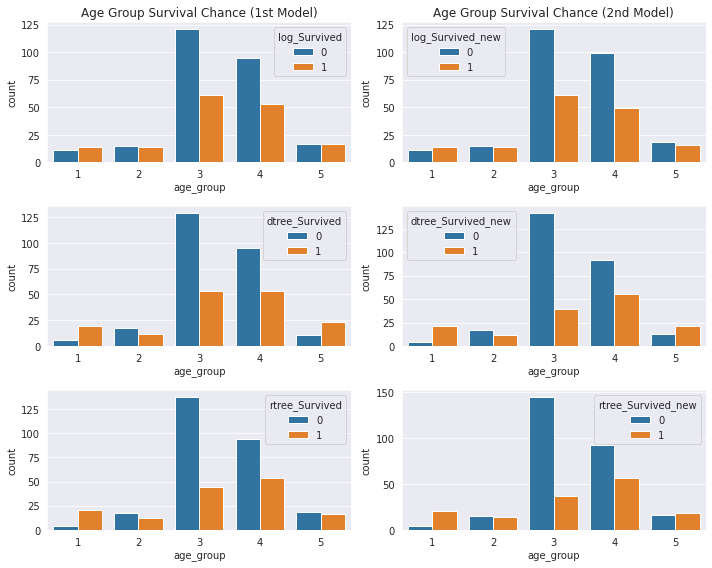

In [129]:
fig,axes= plt.subplots(3,2,figsize=(10,8))

sns.countplot('age_group',data=test_fitted, hue='log_Survived', ax=axes[0,0])
sns.countplot('age_group',data=test_fitted, hue='dtree_Survived', ax=axes[1,0])
sns.countplot('age_group',data=test_fitted, hue='rtree_Survived', ax=axes[2,0])
axes[0,0].set_title('Age Group Survival Chance (1st Model)')

sns.countplot('age_group',data=test_fitted_new, hue='log_Survived_new', ax=axes[0,1])
sns.countplot('age_group',data=test_fitted_new, hue='dtree_Survived_new', ax=axes[1,1])
sns.countplot('age_group',data=test_fitted_new, hue='rtree_Survived_new', ax=axes[2,1])
axes[0,1].set_title('Age Group Survival Chance (2nd Model)')

plt.tight_layout()

For the first modelling, all models except RandomForest show high survival chance for passenger belongin in age group 1(children) and age group 5 (elderly)

As for the second attempt, it seems like except for logistic regression method, people belonging in age group 1 (children) and age group (5) are more likely to survive than not. 
Meanwhile, people in age group 3(young adult) and 4(adult) are more likely to not survive the fall.

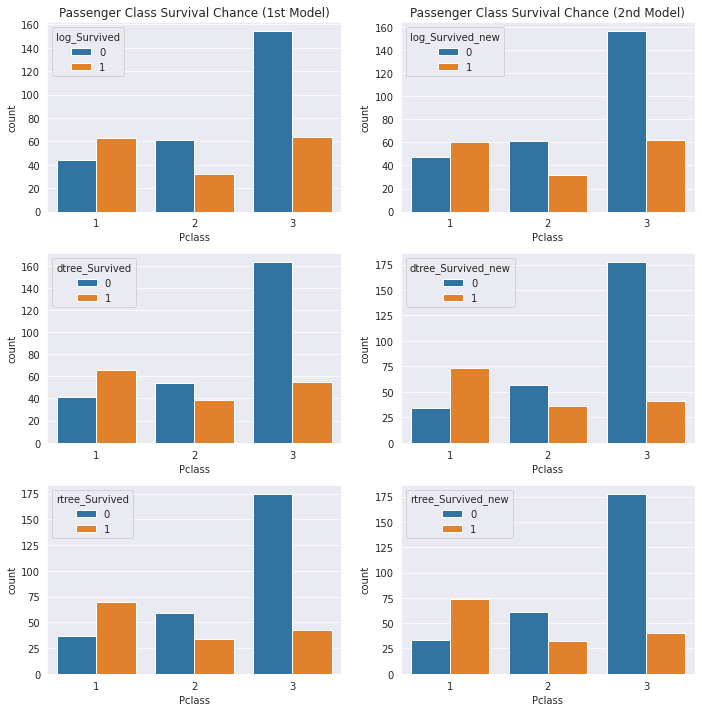

In [133]:
fig,axes= plt.subplots(3,2,figsize=(10,10))

sns.countplot('Pclass',data=test_fitted, hue='log_Survived', ax=axes[0,0])
sns.countplot('Pclass',data=test_fitted, hue='dtree_Survived', ax=axes[1,0])
sns.countplot('Pclass',data=test_fitted, hue='rtree_Survived', ax=axes[2,0])
axes[0,0].set_title('Passenger Class Survival Chance (1st Model)')

sns.countplot('Pclass',data=test_fitted_new, hue='log_Survived_new', ax=axes[0,1])
sns.countplot('Pclass',data=test_fitted_new, hue='dtree_Survived_new', ax=axes[1,1])
sns.countplot('Pclass',data=test_fitted_new, hue='rtree_Survived_new', ax=axes[2,1])
axes[0,1].set_title('Passenger Class Survival Chance (2nd Model)')

plt.tight_layout()

The subplots above show that people who reside in higher cabin class are more likely to survive than those in the lower classes. DecisionTree and RandomForest seems to really favorthe first class passenger, the margin between survival and those who fell victim in both these method are higher than the margin in logistic regression.

The graph also shows that there is not much difference in Class 3 passenger survival chance between the two models, which mean that people in Class 3 pretty much have a far higher chance of not surviving no matter what modelling is used.

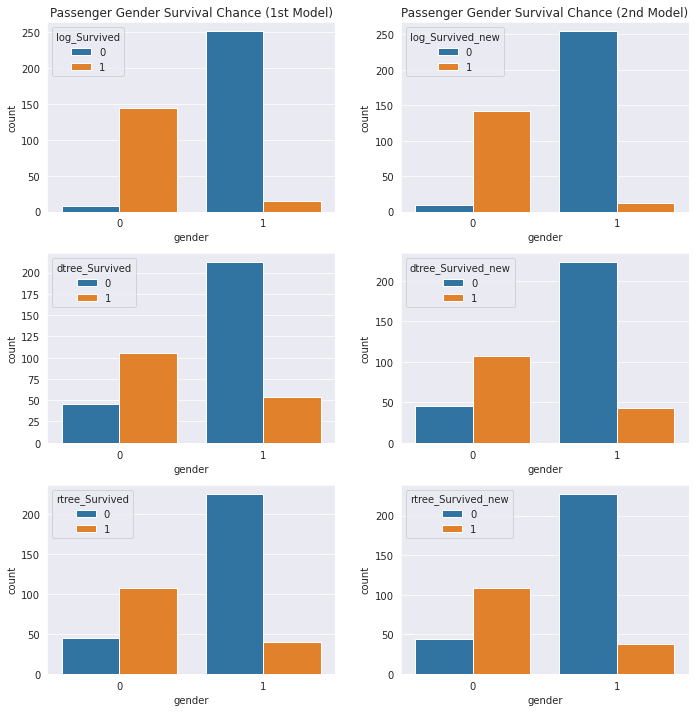

In [134]:
fig,axes= plt.subplots(3,2,figsize=(10,10))

sns.countplot('gender',data=test_fitted, hue='log_Survived', ax=axes[0,0])
sns.countplot('gender',data=test_fitted, hue='dtree_Survived', ax=axes[1,0])
sns.countplot('gender',data=test_fitted, hue='rtree_Survived', ax=axes[2,0])
axes[0,0].set_title('Passenger Gender Survival Chance (1st Model)')

sns.countplot('gender',data=test_fitted_new, hue='log_Survived_new', ax=axes[0,1])
sns.countplot('gender',data=test_fitted_new, hue='dtree_Survived_new', ax=axes[1,1])
sns.countplot('gender',data=test_fitted_new, hue='rtree_Survived_new', ax=axes[2,1])
axes[0,1].set_title('Passenger Gender Survival Chance (2nd Model)')

plt.tight_layout()

Remember that 1 is male and 0 is female (no sexism intended)

The chart above shows that no matter which modelling is used, female group has a far higher survival rate than male group. LogisticRegression model has a clearer margin between survivor and victim for each gender group.

# **RandomForest in the first modelling have the highest accuracy percentage among all models used in this attempt, thus this model's output will be used as final output**

all model evaluation below will be of RandomForest method

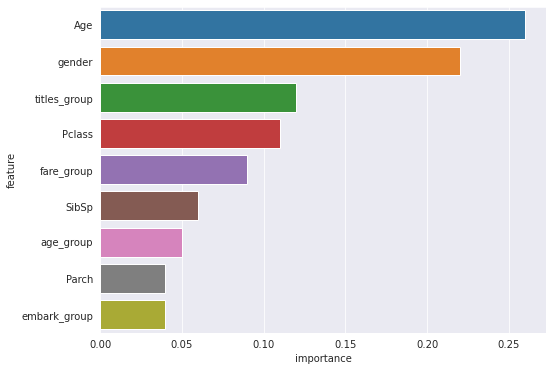

In [143]:
#figuring out column importance order
feature = pd.DataFrame({'feature' : X_train.columns, 
                       'importance': np.round(rtree.feature_importances_, 2)})
feature_rank = feature.sort_values('importance', ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(y = 'feature', x = 'importance' , data=feature_rank)

In [145]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

In [149]:
predict = cross_val_predict(rtree, X_train, y_train)
print('Confusion matrix: \n')
print(confusion_matrix(y_train, predict))
print('\nClassification report:\n')
print(classification_report(y_train, predict))

Confusion matrix: 

[[469  80]
 [ 97 245]]

Classification report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       549
           1       0.75      0.72      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



# Making submission data

In [165]:
submit_file = test_fitted[['PassengerId', 'rtree_Survived']]
submit_file.rename(columns={'rtree_Survived' : 'Survived'}, inplace=True)
submit_file.head(15)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [162]:
submit_file.to_csv('submission.csv', index=False)

# First Attempt Score: 0.75358


# UPDATE: 2nd Try to Improve Score

In [207]:
train.head()

,PassengerId,Survived,Pclass,Age,age_group,gender,titles_group,embark_group,fare_group,is_alone,age_class
0,1,0,3,22.0,3,1,2,1,1,0,9
1,2,1,1,38.0,4,0,3,2,4,0,4
2,3,1,3,26.0,3,0,1,1,1,1,9
3,4,1,1,35.0,4,0,3,1,4,0,4
4,5,0,3,35.0,4,1,2,1,2,1,12


In [167]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,age_group,gender,titles_group,embark_group,fare_group
0,892,3,34.5,0,0,4,1,2,3,2
1,893,3,47.0,1,0,4,0,3,1,1
2,894,2,62.0,0,0,5,1,2,3,2
3,895,3,27.0,0,0,3,1,2,1,2
4,896,3,22.0,1,1,3,0,3,1,2


this method will try to categorize SibSp and Parch columns into 1 column

In [168]:
def is_alone(cols):
    SibSp =cols[0]
    Parch = cols[1]
    
    if SibSp == 0 and Parch == 0:
        return 1
    else: 
        return 0

In [169]:
train['is_alone'] = train[['SibSp', 'Parch']].apply(is_alone, axis=1)

In [171]:
train = train.drop(['SibSp', 'Parch'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,age_group,gender,titles_group,embark_group,fare_group,is_alone
0,1,0,3,22.0,3,1,2,1,1,0
1,2,1,1,38.0,4,0,3,2,4,0
2,3,1,3,26.0,3,0,1,1,1,1
3,4,1,1,35.0,4,0,3,1,4,0
4,5,0,3,35.0,4,1,2,1,2,1


In [172]:
test['is_alone'] = test[['SibSp', 'Parch']].apply(is_alone, axis =1)
test = test.drop(['SibSp', 'Parch'], axis=1)
test.head()

,PassengerId,Pclass,Age,age_group,gender,titles_group,embark_group,fare_group,is_alone
0,892,3,34.5,4,1,2,3,2,1
1,893,3,47.0,4,0,3,1,1,0
2,894,2,62.0,5,1,2,3,2,1
3,895,3,27.0,3,1,2,1,2,1
4,896,3,22.0,3,0,3,1,2,0


In [195]:
#more category column of age*class
def age_class(cols):
    Pclass= cols[0]
    Age = cols[1]
    
    return Pclass*Age

In [199]:
train['age_class'] = train[['Pclass', 'age_group']].apply(age_class, axis=1)
test['age_class'] = test[['Pclass', 'age_group']].apply(age_class, axis=1)

In [200]:
train.head()

,PassengerId,Survived,Pclass,Age,age_group,gender,titles_group,embark_group,fare_group,is_alone,age_class
0,1,0,3,22.0,3,1,2,1,1,0,9
1,2,1,1,38.0,4,0,3,2,4,0,4
2,3,1,3,26.0,3,0,1,1,1,1,9
3,4,1,1,35.0,4,0,3,1,4,0,4
4,5,0,3,35.0,4,1,2,1,2,1,12


In [201]:
test.head()

,PassengerId,Pclass,Age,age_group,gender,titles_group,embark_group,fare_group,is_alone,age_class
0,892,3,34.5,4,1,2,3,2,1,12
1,893,3,47.0,4,0,3,1,1,0,12
2,894,2,62.0,5,1,2,3,2,1,10
3,895,3,27.0,3,1,2,1,2,1,9
4,896,3,22.0,3,0,3,1,2,0,9


In [202]:
#modeling using RandomForest

X_train = train.drop(['PassengerId', 'Survived', 'Age'], axis=1)
y_train = train['Survived']
X_test = test.drop(['PassengerId', 'Age'], axis=1)

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest_acc = round(random_forest.score(X_train, y_train)*100,2)
predict = cross_val_predict(rtree, X_train, y_train)

print('Random Forest Updated Acc: ' + str(random_forest_acc))

Random Forest Updated Acc: 88.78


In [203]:
print(classification_report(y_train, predict))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       549
           1       0.80      0.71      0.75       342

    accuracy                           0.82       891
   macro avg       0.82      0.80      0.81       891
weighted avg       0.82      0.82      0.82       891



In [204]:
random_forest_model = pd.DataFrame({
    'Survived': y_pred
})

In [205]:
survivor_updated = pd.DataFrame({
    'PassengerId' : test['PassengerId'],
    'Survived' : y_pred
})
survivor_updated.head(15)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [206]:
survivor_updated.to_csv('second_submit.csv', index=False)

# 2nd Attempt Score: 0.76315

# Third Attempt

In [213]:
#modeling using RandomForest

X_train = train.drop(['PassengerId', 'Survived', 'age_group', 'Age'], axis=1)
y_train = train['Survived']
X_test = test.drop(['PassengerId', 'age_group', 'Age'], axis=1)

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_third = random_forest.predict(X_test)
random_forest_acc = round(random_forest.score(X_train, y_train)*100,2)
predict = cross_val_predict(rtree, X_train, y_train)

print('Random Forest Updated Acc: ' + str(random_forest_acc))

Random Forest Updated Acc: 94.84


In [210]:
survivor_updated_again = pd.DataFrame({
    'PassengerId' : test['PassengerId'],
    'Survived' : y_pred_third
})
survivor_updated_again.head(15)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [211]:
survivor_updated_again.to_csv('third_submit.csv', index=False)